## Import Packages

In [1]:
import sklearn
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import shap
import time

## Data Cleansing Time

In [2]:
dtrain = pd.read_csv("train.csv")

In [3]:
dtrain.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# Remove Cabin from the training and test sets
# How to fix Age? Drop those that are missing Age

In [5]:
dtrain = dtrain[(dtrain['Age'].isna() == False) & (dtrain['Embarked'].isna() == False)].drop("Cabin", axis=1)

In [6]:
dtrain.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [7]:
dtrain['Prefix'] = dtrain['Name'].str.extract(r',\s(.*)\.')
dtrain['Prefix'].value_counts()

Mr                          398
Miss                        145
Mrs                         106
Master                       36
Dr                            6
Rev                           6
Major                         2
Mlle                          2
Col                           2
the Countess                  1
Ms                            1
Lady                          1
Capt                          1
Mrs. Martin (Elizabeth L      1
Sir                           1
Don                           1
Mme                           1
Jonkheer                      1
Name: Prefix, dtype: int64

In [8]:
dtrainY = dtrain[['Survived']]
dtrainX = dtrain[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Prefix']]        

In [9]:
dtrainX.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Prefix
0,3,male,22.0,1,0,7.2500,S,Mr
1,1,female,38.0,1,0,71.2833,C,Mrs
2,3,female,26.0,0,0,7.9250,S,Miss
3,1,female,35.0,1,0,53.1000,S,Mrs
4,3,male,35.0,0,0,8.0500,S,Mr


![caption](TitanicInformation.png)

In [10]:
pclassdum = pd.get_dummies(dtrainX['Pclass'], prefix=['Pclass'])
sexdum = pd.get_dummies(dtrainX['Sex'], prefix=['Sex'])
sibspdum = pd.get_dummies(dtrainX['SibSp'], prefix=['SibSp'])
parchdum = pd.get_dummies(dtrainX['Parch'], prefix=['Parch'])
embarkeddum = pd.get_dummies(dtrainX['Embarked'], prefix=['Embarked'])
prefixdum = pd.get_dummies(dtrainX['Prefix'], prefix=['Prefix'])

In [11]:
dtrainX1 = dtrainX.merge(pclassdum, left_index=True, right_index=True).drop('Pclass', axis=1)

In [12]:
dtrainX1 = dtrainX1.merge(sexdum, left_index=True, right_index=True).drop('Sex', axis=1)

In [13]:
dtrainX1 = dtrainX1.merge(sibspdum, left_index=True, right_index=True).drop('SibSp', axis=1)

In [14]:
dtrainX1 = dtrainX1.merge(parchdum, left_index=True, right_index=True).drop('Parch', axis=1)

In [15]:
dtrainX1 = dtrainX1.merge(embarkeddum, left_index=True, right_index=True).drop('Embarked', axis=1)

In [16]:
dtrainX1 = dtrainX1.merge(prefixdum, left_index=True, right_index=True).drop('Prefix', axis=1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(dtrainX1, dtrainY, test_size=0.33, random_state=42)

## Ignore Warning

In [18]:
import warnings
warnings.filterwarnings("ignore")

## Modeling - K-nearest Neighbors

Accuracy:0.6638297872340425



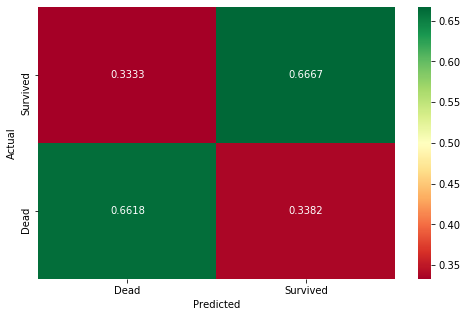

In [22]:
knn = sklearn.neighbors.KNeighborsClassifier()
classifier = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

print("Accuracy:" + str(accuracy_score(y_test, y_pred)))
print('')

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_normalized, annot=True, fmt='.4f', xticklabels=['Dead', 'Survived'], yticklabels=['Dead', 'Survived'], cmap="RdYlGn")
ax.set_ylim([0,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [23]:
shap.initjs()

### Explain a single prediction from the test

In [54]:
explainer = shap.KernelExplainer(knn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[0,:])

Using 477 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


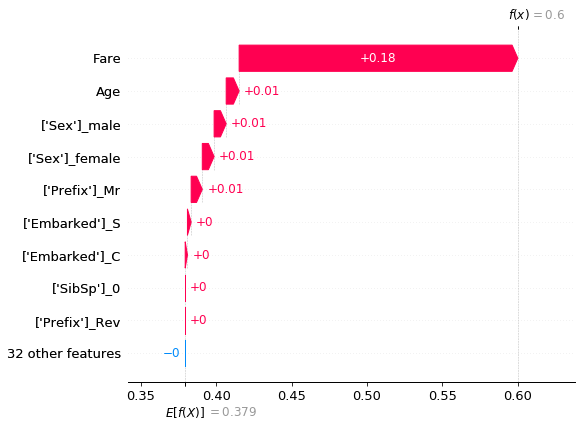

In [25]:
shap.waterfall_plot(explainer.expected_value[1], shap_values[1],feature_names=X_test.columns.values )

In [26]:
shap_values = explainer.shap_values(X_test.iloc[15,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[15,:])

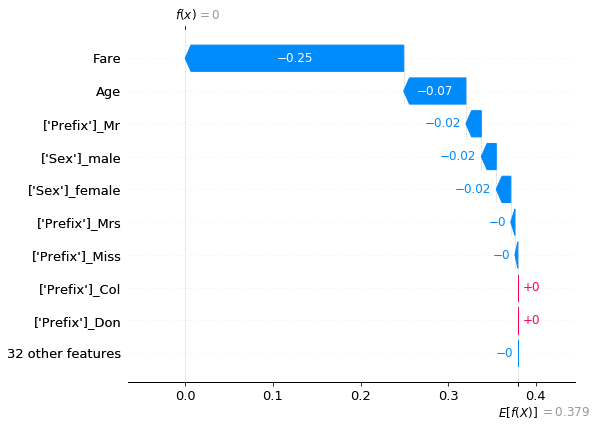

In [27]:
shap.waterfall_plot(explainer.expected_value[1], shap_values[1],feature_names=X_test.columns.values )

### Explain all the predictions in the test set

In [28]:
shap_values = explainer.shap_values(X_test)

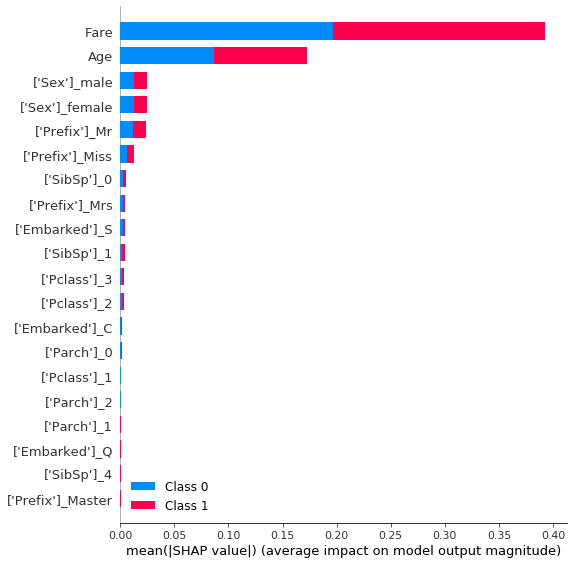

In [29]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

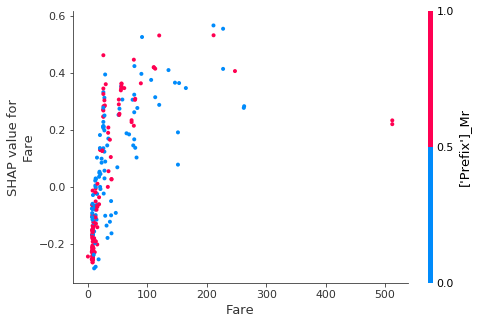

In [30]:
shap.dependence_plot('Fare', shap_values[1], X_test)

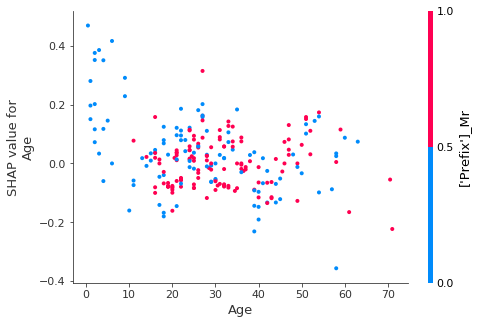

In [31]:
shap.dependence_plot('Age', shap_values[1], X_test)

## Modeling - Neural Network

In [36]:
X_train, X_test, y_train, y_test = train_test_split(dtrainX1, dtrainY, test_size=0.33, random_state=42)

Train Accuracy:0.8469601677148847
Test Accuracy:0.7957446808510639



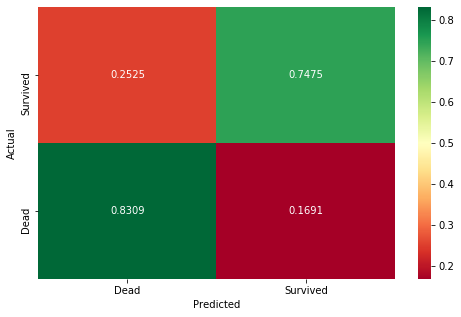

In [53]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='adam', learning_rate='constant', hidden_layer_sizes=(10,10,10), random_state=0)
classifier = nn.fit(X_train, y_train)
y_pred_train = nn.predict(X_train)
y_pred_test = nn.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

print('Train Accuracy:' + str(accuracy_score(y_train, y_pred_train)))
print("Test Accuracy:" + str(accuracy_score(y_test, y_pred_test)))
print('')

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_normalized, annot=True, fmt='.4f', xticklabels=['Dead', 'Survived'], yticklabels=['Dead', 'Survived'], cmap="RdYlGn")
ax.set_ylim([0,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Explain a Single Prediction from Test

In [55]:
explainer = shap.KernelExplainer(nn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[0,:])

Using 477 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


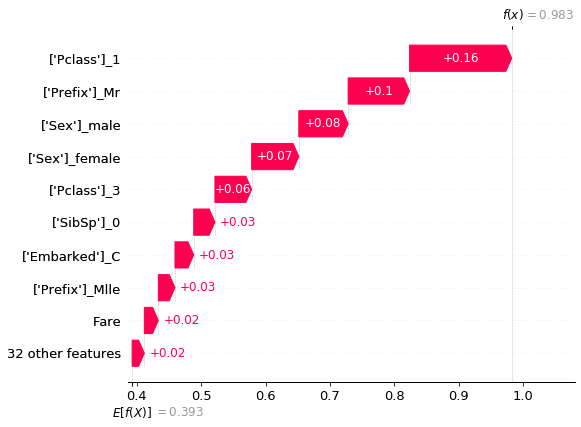

In [56]:
shap.waterfall_plot(explainer.expected_value[1], shap_values[1],feature_names=X_test.columns.values )

In [57]:
shap_values = explainer.shap_values(X_test.iloc[15,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[15,:])

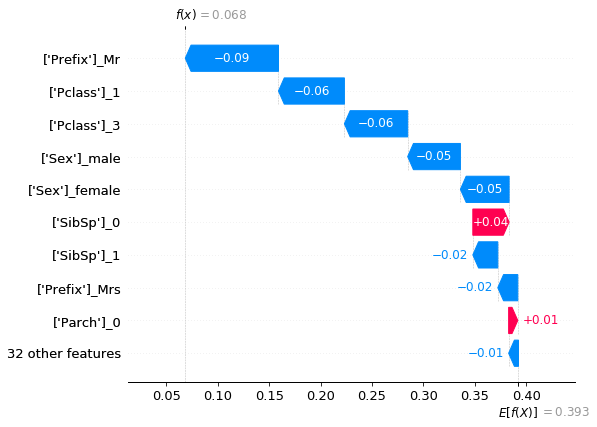

In [58]:
shap.waterfall_plot(explainer.expected_value[1], shap_values[1],feature_names=X_test.columns.values )

### Explain All Predictions in the Test Set

In [59]:
shap_values = explainer.shap_values(X_test)

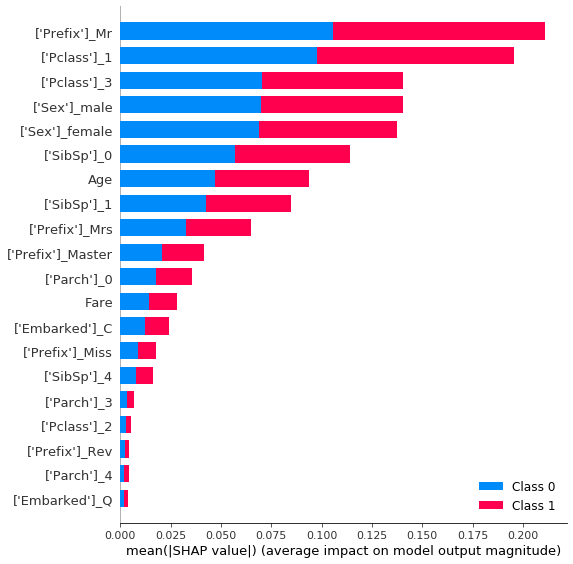

In [60]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

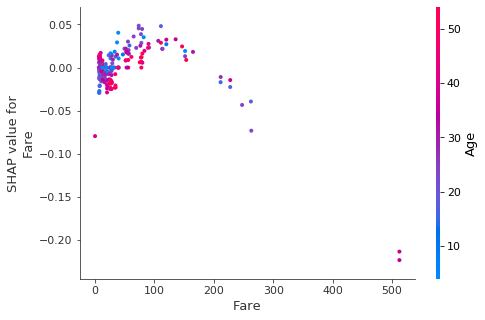

In [61]:
shap.dependence_plot('Fare', shap_values[1], X_test)

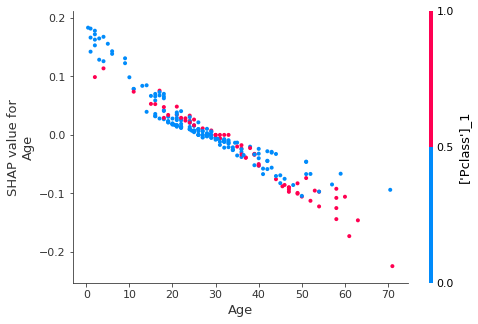

In [62]:
shap.dependence_plot('Age', shap_values[1], X_test)

## Modeling - Random Forest

In [65]:
X_train, X_test, y_train, y_test = train_test_split(dtrainX1, dtrainY, test_size=0.33, random_state=42)

Train Accuracy:0.9245283018867925
Test Accuracy:0.7787234042553192



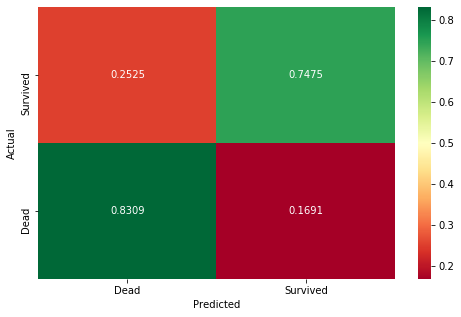

In [72]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(n_estimators=200, criterion='gini', min_samples_split=10, random_state=0)
classifier = rforest.fit(X_train, y_train)
y_pred_train = rforest.predict(X_train)
y_pred_test = rforest.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

print('Train Accuracy:' + str(accuracy_score(y_train, y_pred_train)))
print("Test Accuracy:" + str(accuracy_score(y_test, y_pred_test)))
print('')

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(cm_normalized, annot=True, fmt='.4f', xticklabels=['Dead', 'Survived'], yticklabels=['Dead', 'Survived'], cmap="RdYlGn")
ax.set_ylim([0,2])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

### Explain a single prediction from Test

In [73]:
explainer = shap.TreeExplainer(model=classifier, data=X_train, model_output='probability')
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[0,:])

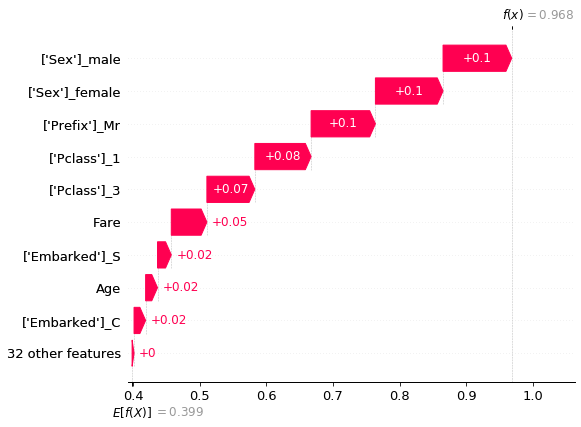

In [74]:
shap.waterfall_plot(explainer.expected_value[1], shap_values[1],feature_names=X_test.columns.values )

In [75]:
shap_values = explainer.shap_values(X_test.iloc[15,:])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[15,:])

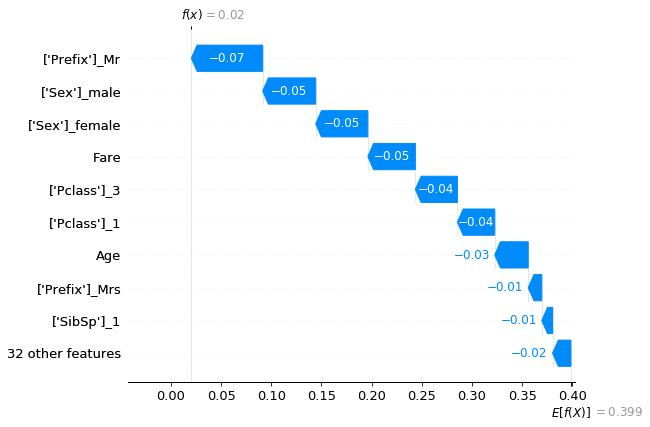

In [76]:
shap.waterfall_plot(explainer.expected_value[1], shap_values[1],feature_names=X_test.columns.values )

### Explain All Predictions in the Test Set

In [77]:
shap_values = explainer.shap_values(X_test)

100%|===================| 468/470 [00:49<00:00]        

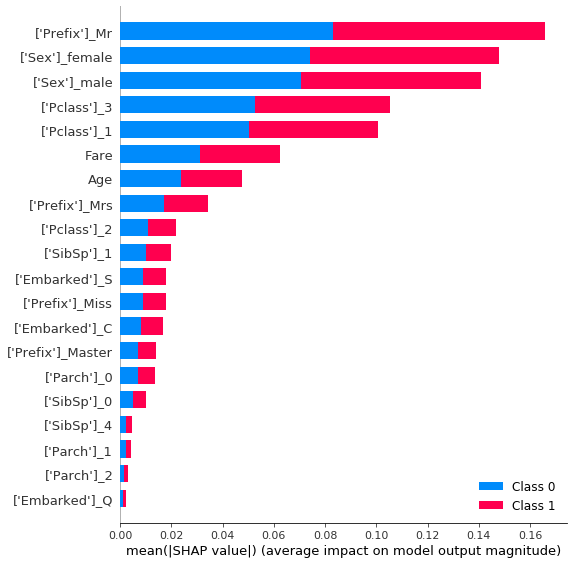

In [78]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

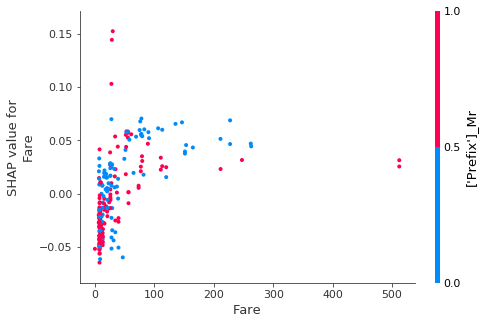

In [79]:
shap.dependence_plot('Fare', shap_values[1], X_test)

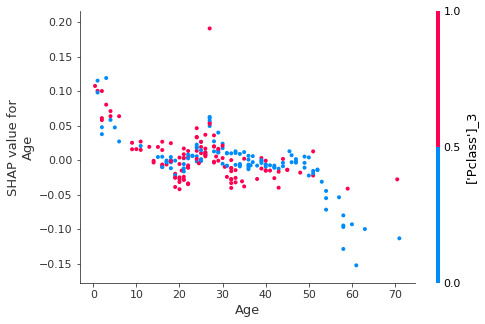

In [80]:
shap.dependence_plot('Age', shap_values[1], X_test)

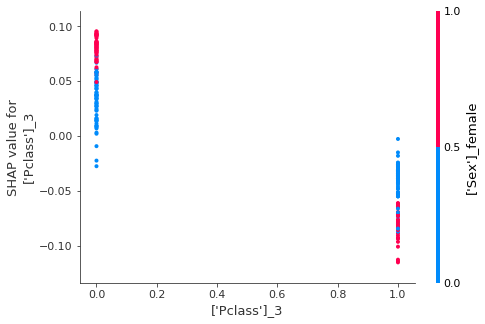

In [84]:
shap.dependence_plot("['Pclass']_3", shap_values[1], X_test)